This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. *The objective is to predict based on diagnostic measurements whether a patient has diabetes*.

## Dataset information

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Relevant papers

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). [Using the ADAP learning algorithm to forecast the onset of diabetes mellitus](http://rexa.info/paper/04587c10a7c92baa01948f71f2513d5928fe8e81). *In Proceedings of the Symposium on Computer Applications and Medical Care* (pp. 261--265). IEEE Computer Society Press.

## Data Attributes:

**Pregnancies**: Number of times pregnant

**Glucose**: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

**BloodPressure**: Diastolic blood pressure (mm Hg)

**SkinThickness**: Triceps skin fold thickness (mm)

**Insulin**: 2-Hour serum insulin (mu U/ml)

**BMI**: Body mass index (weight in kg/(height in m)^2)

**DiabetesPedigreeFunction**: Diabetes pedigree function

**Age**: Age (years)

**Outcome**: Class variable (0 or 1)

[link to example](https://www.kaggle.com/hugues/d/uciml/pima-indians-diabetes-database/basic-ml-best-of-10-classifiers/notebook)

[link to dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database)

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#for table-like data and matrices
import numpy as np
import pandas as pd

#Visualisation
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

#Configure Visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

In [3]:
indata = pd.read_csv("./input/diabetes.csv")
indata.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
describe_more(indata)

,Datatype,Levels,Variable
8,int64,2,Outcome
0,int64,17,Pregnancies
2,int64,47,BloodPressure
3,int64,51,SkinThickness
7,int64,52,Age
1,int64,136,Glucose
4,int64,186,Insulin
5,float64,248,BMI
6,float64,517,DiabetesPedigreeFunction


In [5]:
print('# of rows', len(indata))
print('# of columns', len(indata.columns))
indata.describe()

# of rows 768
# of columns 9


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
#Checking for missing data
print('# of missing data', indata.isnull().any().sum())

# of missing data 0


Pre-Processing and Analysis of the data

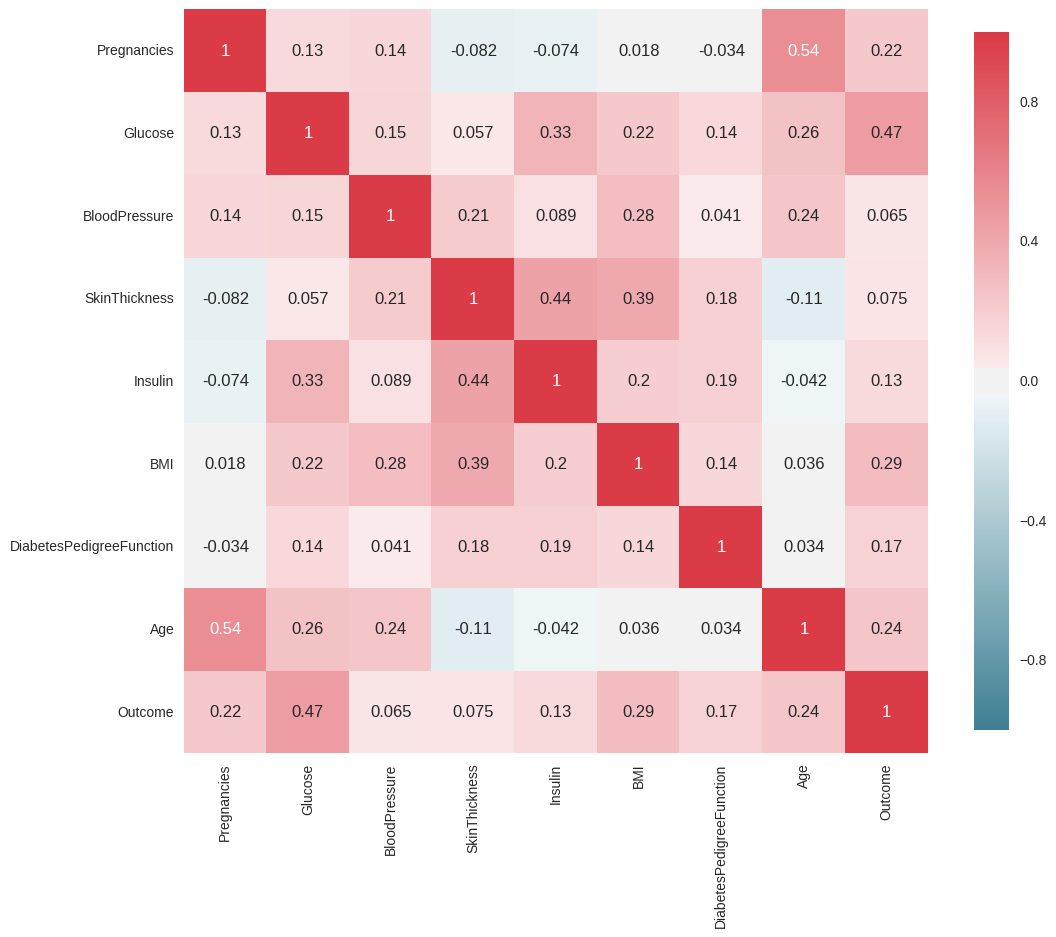

In [7]:
# sns.heatmap(indata.corr())
plot_correlation_map(indata)

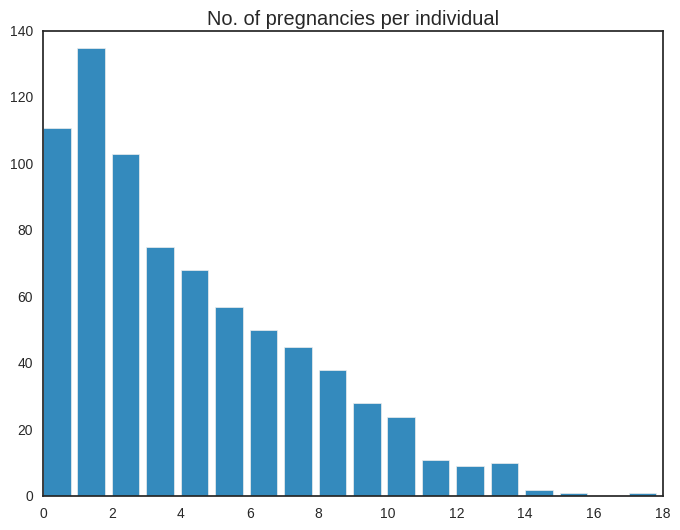

In [8]:
preg_count = indata.groupby('Pregnancies').Pregnancies.count()

values = preg_count.values
indx   = preg_count.index
# print(indx)
# print(values)
# print(sum(values))

mean = sum(values)/len(indx)
variance = np.sqrt(sum((values-mean)**2)/len(indx))

plt.bar(indx, values)
plt.title('No. of pregnancies per individual')
plt.xticks(rotation='horizontal')
plt.show()

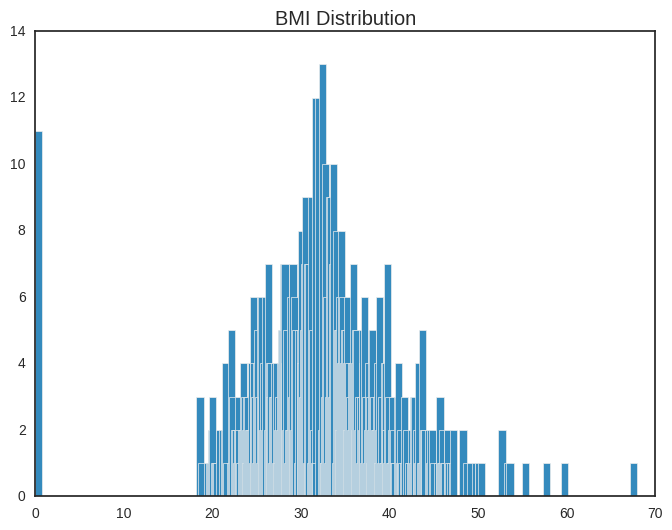

In [9]:
preg_count = indata.groupby('BMI').BMI.count()

values = preg_count.values
indx   = preg_count.index
# print(indx)
# print(values)
# print(sum(values))

mean = sum(values)/len(indx)
variance = np.sqrt(sum((values-mean)**2)/len(indx))

plt.bar(indx, values)
plt.title('BMI Distribution')
plt.xticks(rotation='horizontal')
plt.show()

In [10]:
#filter bad values
print(indata.min())
print("-----------------------------------")
print("-----------------------------------")
print(indata.max())
print("-----------------------------------")
print("-----------------------------------")
print(indata.idxmin())
print("-----------------------------------")
print("-----------------------------------")
print(indata.idxmax())

Pregnancies                  0.000
Glucose                      0.000
BloodPressure                0.000
SkinThickness                0.000
Insulin                      0.000
BMI                          0.000
DiabetesPedigreeFunction     0.078
Age                         21.000
Outcome                      0.000
dtype: float64
-----------------------------------
-----------------------------------
Pregnancies                  17.00
Glucose                     199.00
BloodPressure               122.00
SkinThickness                99.00
Insulin                     846.00
BMI                          67.10
DiabetesPedigreeFunction      2.42
Age                          81.00
Outcome                       1.00
dtype: float64
-----------------------------------
-----------------------------------
Pregnancies                   4
Glucose                      75
BloodPressure                 7
SkinThickness                 2
Insulin                       0
BMI                           9
Diab

In [11]:
r_indx = 9
# print("height", indata.iloc[r_indx,6])
# print("weight", indata.iloc[r_indx,3])
print(indata.iloc[r_indx,])
# print("age", indata.iloc[r_indx,23])

Pregnancies                   8.000
Glucose                     125.000
BloodPressure                96.000
SkinThickness                 0.000
Insulin                       0.000
BMI                           0.000
DiabetesPedigreeFunction      0.232
Age                          54.000
Outcome                       1.000
Name: 9, dtype: float64


In [12]:
#To check for outlier points

low = .002
high = .998
qdf = indata.quantile([low, high])

# print(qdf.loc[low,'age'])
qdf

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0.002,0.000,0.000,0.000,0.000,0.000,0.0000,0.084534,21.000,0.0
0.998,14.466,197.466,111.864,61.398,709.824,58.2786,2.307106,70.932,1.0


In [13]:
df = indata.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [14]:
from scipy import stats
df = indata[(np.abs(stats.zscore(df)) < 3.6).all(axis=1)].copy()
# df = df[df.BMI != 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 730 non-null int64
Glucose                     730 non-null int64
BloodPressure               730 non-null int64
SkinThickness               730 non-null int64
Insulin                     730 non-null int64
BMI                         730 non-null float64
DiabetesPedigreeFunction    730 non-null float64
Age                         730 non-null int64
Outcome                     730 non-null int64
dtypes: float64(2), int64(7)
memory usage: 57.0 KB


In [17]:
#To check for outlier points
low = .002
high = .998
qdf = df.quantile([low, high])
qdf

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0.002,0.0,56.458,0.000,0.000,0.0,18.2000,0.084458,21.000,0.0
0.998,14.0,197.542,112.168,55.084,480.0,54.1756,1.469130,69.542,1.0


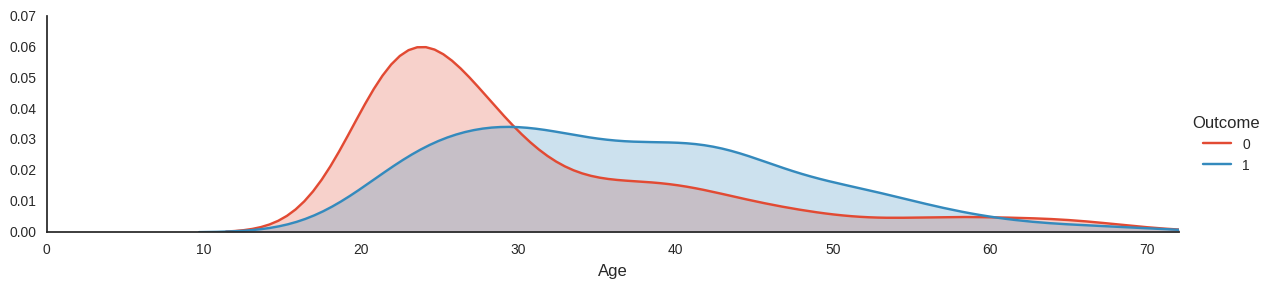

In [42]:
#distribution of males and females from different age groups with and without diabetes
plot_distribution( df , var = 'Age' , target = 'Outcome')

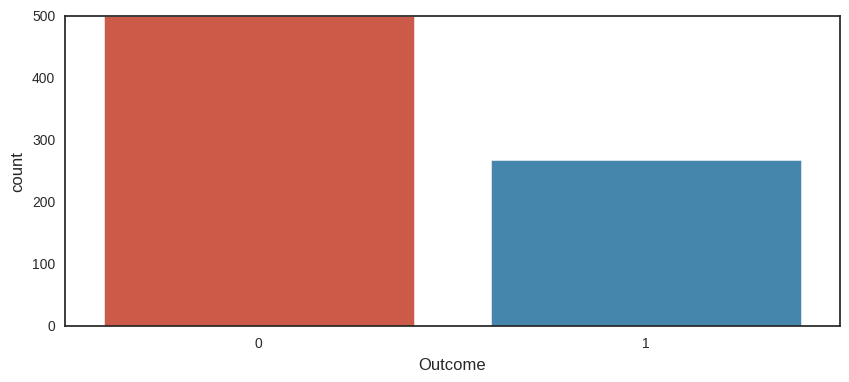

In [46]:
# response - ppl who have diabetes!!!
fig, (axis1) = plt.subplots(1,1,figsize=(10,4))
sns.countplot(x=indata["Outcome"], order=[0,1], ax=axis1)

In [40]:
# f = open("/home/grdstu/Documents/Courses/CS7641_ML/Assignments/1/src/input/diabetes.csv")
# f.readline()  # skip the header
# data = np.loadtxt(f, delimiter = ',')
# X = data[:, :-1]
# y = data[:, -1]

In [18]:
#Filtered Data
X = df.drop(["Outcome"],axis=1)
y = df["Outcome"]

In [55]:
#All Data
X = indata.drop(["Outcome"],axis=1)
y = indata["Outcome"]

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [23]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "Neural Net", "AdaBoost"]
classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="rbf"),
    DecisionTreeClassifier(),
    MLPClassifier(),
    AdaBoostClassifier()
]

In [24]:
from sklearn.model_selection import cross_val_score

# iterate over classifiers
results = {}
for name, clf in zip(names, classifiers):
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    results[name] = scores


For full data

In [58]:
for name, scores in results.items():
    print("%20s | Accuracy: %0.2f%% (+/- %0.2f%%)" % (name, 100*scores.mean(), 100*scores.std() * 2))

            AdaBoost | Accuracy: 72.57% (+/- 8.32%)
             RBF SVM | Accuracy: 64.24% (+/- 0.44%)
          Neural Net | Accuracy: 65.79% (+/- 7.77%)
          Linear SVM | Accuracy: 76.04% (+/- 5.58%)
       Decision Tree | Accuracy: 66.15% (+/- 4.79%)
   Nearest Neighbors | Accuracy: 71.18% (+/- 7.56%)


For filtered data

In [25]:
for name, scores in results.items():
    print("%20s | Accuracy: %0.2f%% (+/- %0.2f%%)" % (name, 100*scores.mean(), 100*scores.std() * 2))

          Linear SVM | Accuracy: 78.78% (+/- 2.95%)
            AdaBoost | Accuracy: 77.88% (+/- 4.62%)
       Decision Tree | Accuracy: 71.11% (+/- 6.15%)
          Neural Net | Accuracy: 68.02% (+/- 4.51%)
   Nearest Neighbors | Accuracy: 72.76% (+/- 2.99%)
             RBF SVM | Accuracy: 67.28% (+/- 0.39%)


In [28]:
# dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
# dt.fit(X, y)
model  = DecisionTreeClassifier(criterion = 'entropy')
model  = model.fit(X_train, y_train)

In [29]:
import os
import subprocess

In [30]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "tree.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [31]:
visualize_tree(model , df.columns)

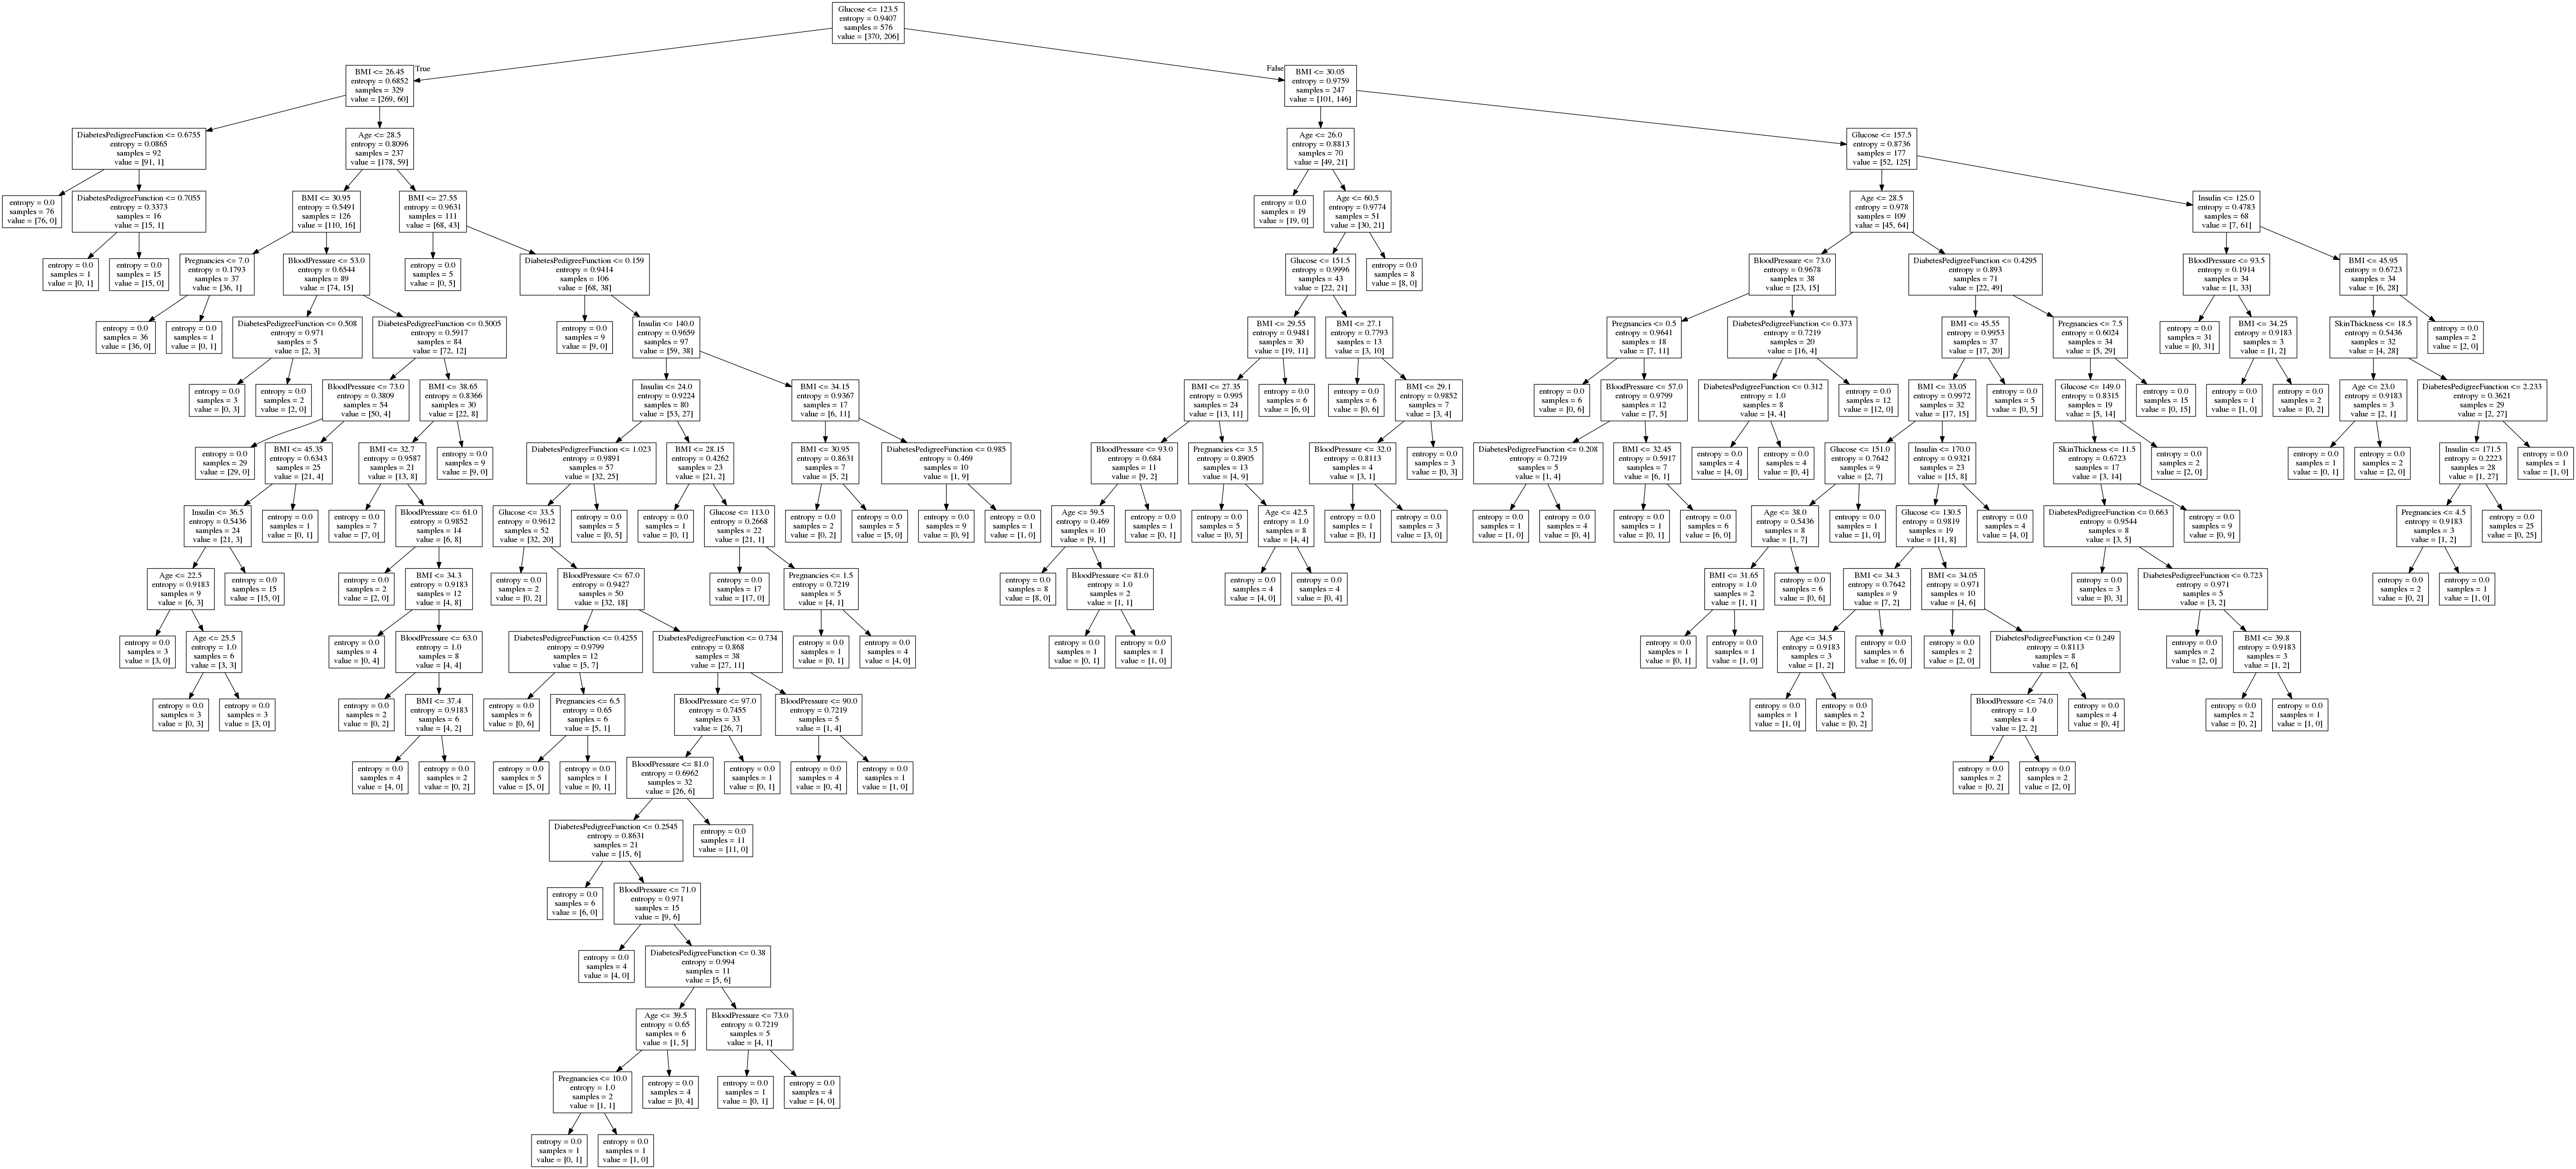

In [44]:
from IPython.display import Image
Image("./dt.png")

In [33]:
import pydotplus as pydot
import sklearn.tree as tree
from IPython.display import Image
from sklearn.externals.six import StringIO

In [42]:
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=indata.columns,    
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = pydot.graph_from_dot_data(dot_data)

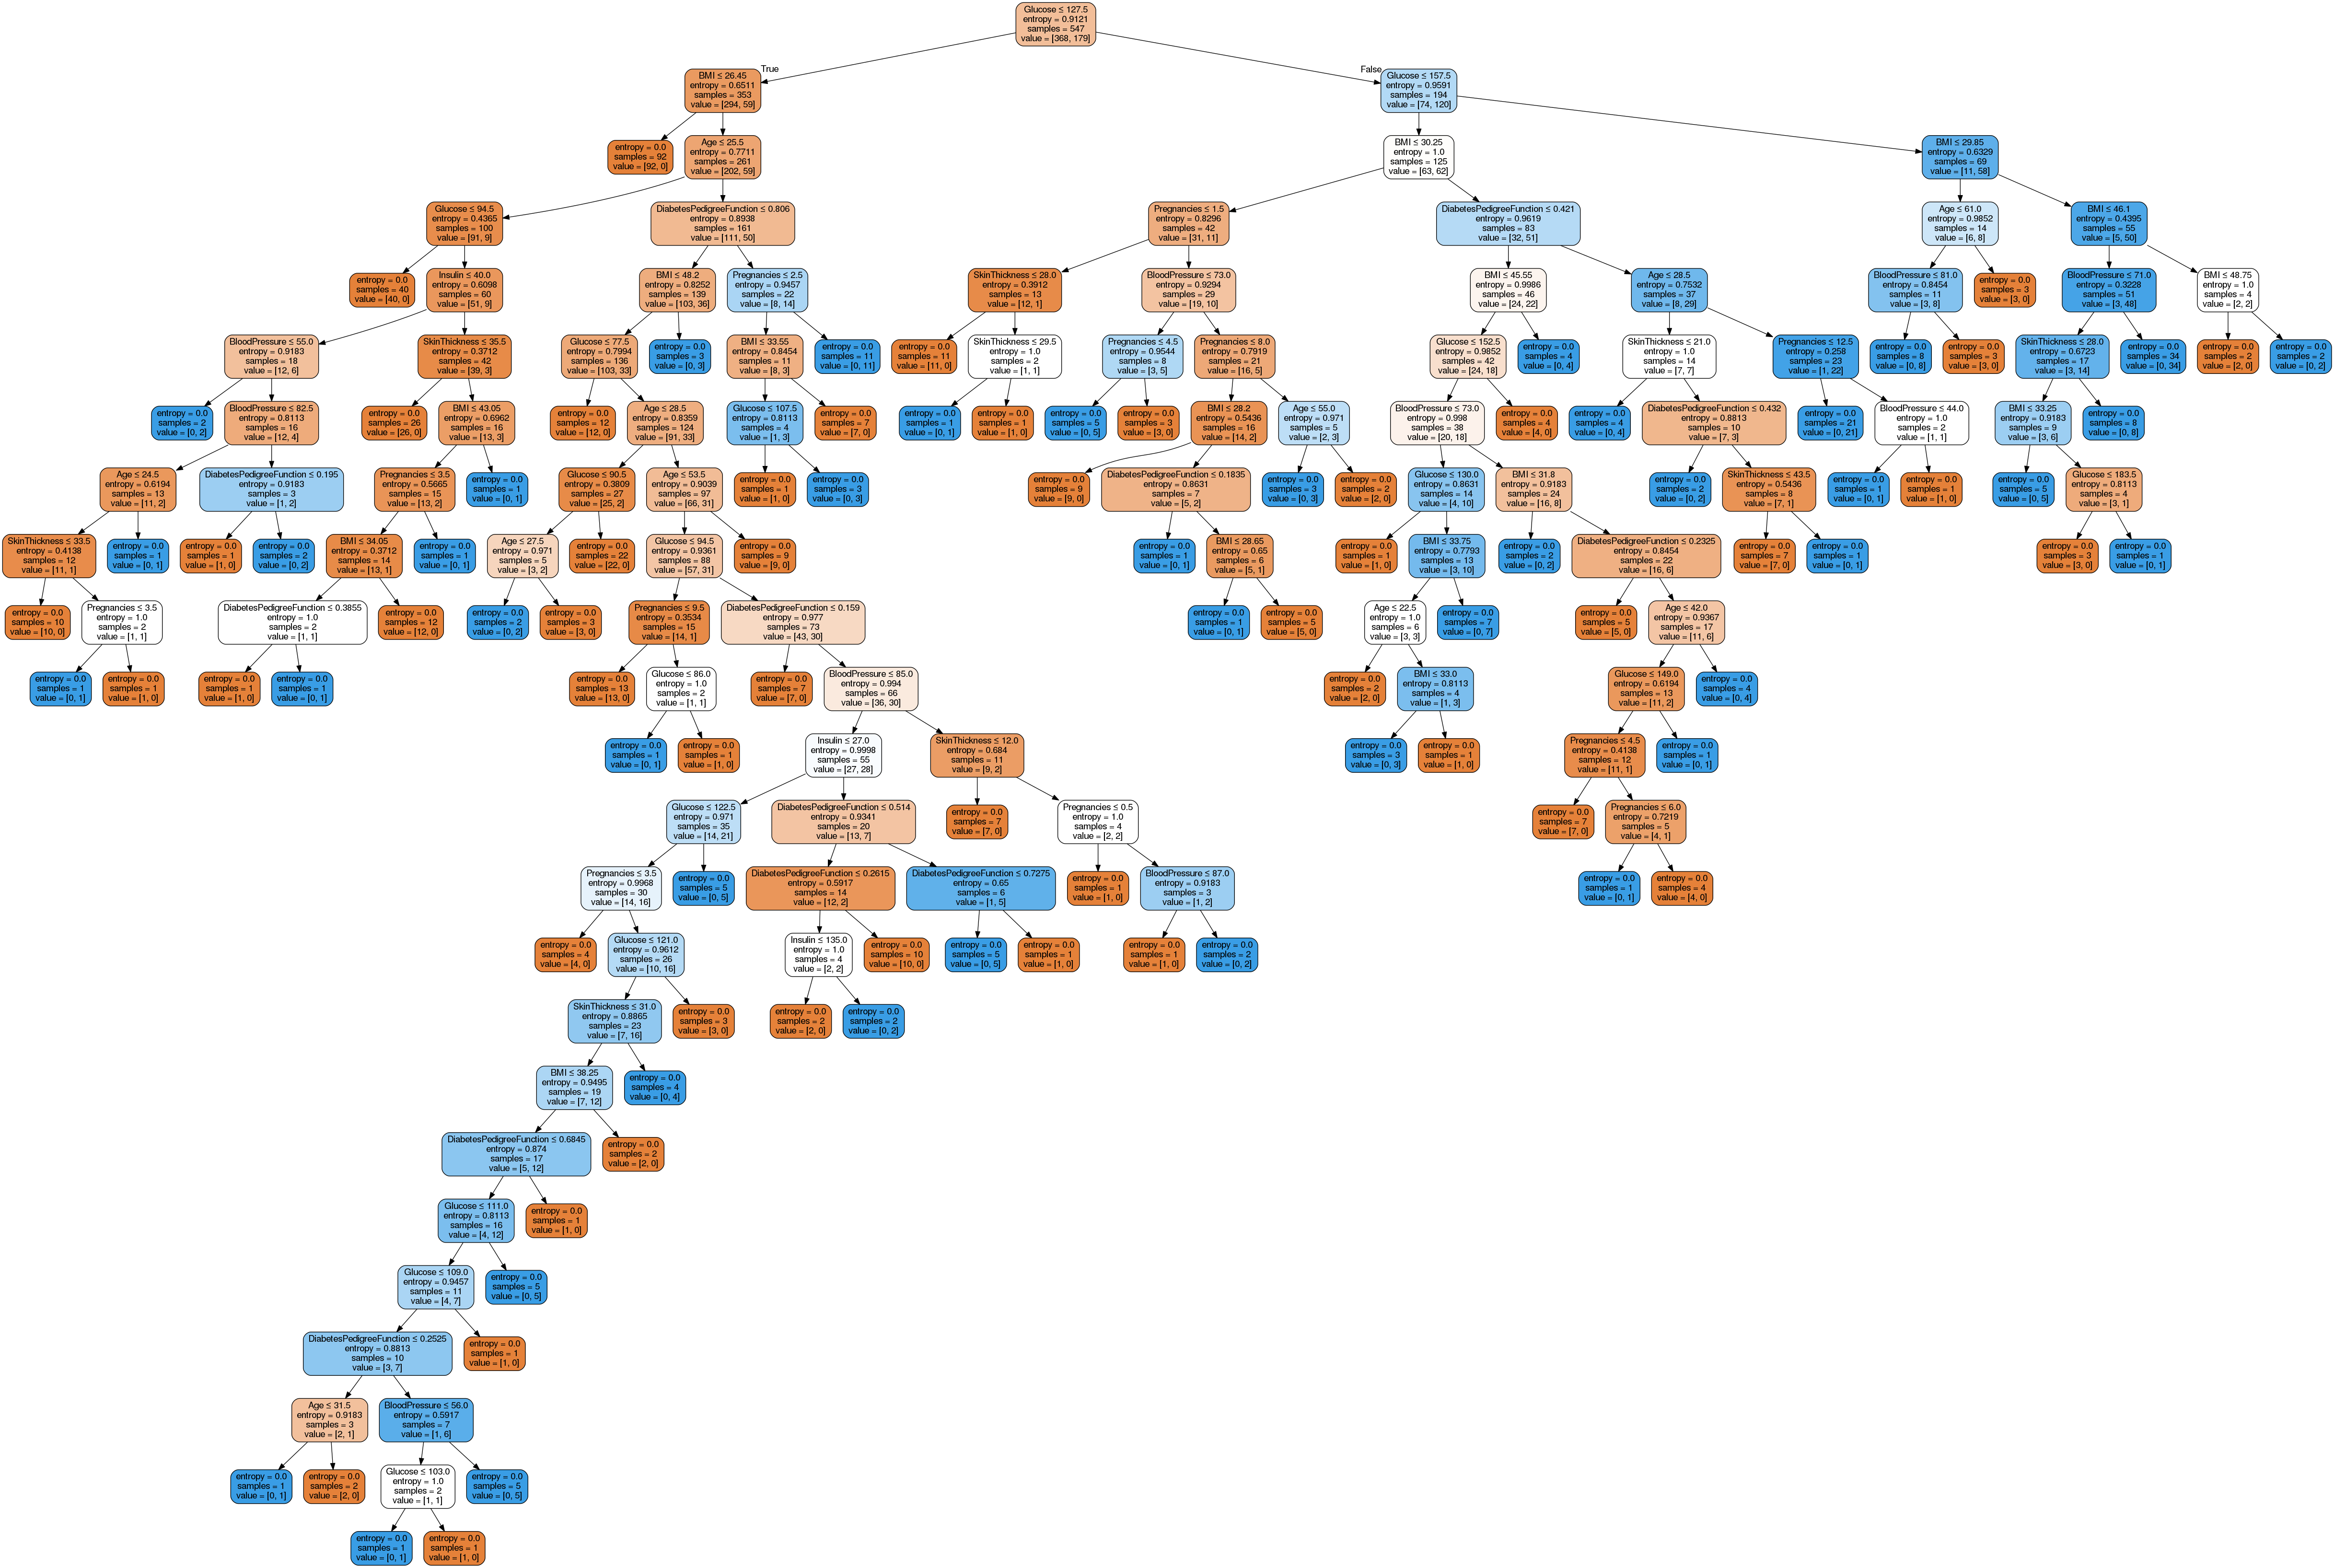

In [43]:
Image(graph.create_png())

In [49]:
from sklearn.grid_search import GridSearchCV

clf = SVC(kernel="linear")

# prepare a range of values to test
param_grid = [
  {'C': [0.01, .01, .1, 1, 10], 'kernel': ['linear']},
 ]

grid = GridSearchCV(estimator=clf, param_grid=param_grid)
grid.fit(X_train, y_train)
print(grid)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [0.01, 0.01, 0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


In [50]:
# summarize the results of the grid search
print("Best score: %0.2f%%" % (100*grid.best_score_))
print("Best estimator for parameter C: %f" % (grid.best_estimator_.C))

Best score: 79.16%
Best estimator for parameter C: 1.000000


In [47]:
from sklearn.grid_search import GridSearchCV

clf = SVC(kernel="rbf")

# prepare a range of values to test
param_grid = [
  {'C': [0.01, .01, .1, 1, 10], 'kernel': ['rbf']},
 ]

grid = GridSearchCV(estimator=clf, param_grid=param_grid)
grid.fit(X_train, y_train)
print(grid)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'C': [0.01, 0.01, 0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


In [48]:
# summarize the results of the grid search
print("Best score: %0.2f%%" % (100*grid.best_score_))
print("Best estimator for parameter C: %f" % (grid.best_estimator_.C))

Best score: 67.28%
Best estimator for parameter C: 0.010000


In [58]:
from sklearn.grid_search import GridSearchCV

clf =  MLPClassifier(hidden_layer_sizes=(5,), alpha=1e-5,
                    solver='adam', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

# prepare a range of values to test
param_grid = [
  {'hidden_layer_sizes': [(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,),(12,),(13,),(14,),(15,)], 'solver': ['adam']},
 ]
grid = GridSearchCV(estimator=clf, param_grid=param_grid)
grid.fit(X_train, y_train)
print(grid)

Iteration 1, loss = 0.64646805
Iteration 2, loss = 0.63850648
Iteration 3, loss = 0.63255565
Iteration 4, loss = 0.63218278
Iteration 5, loss = 0.63503957
Iteration 6, loss = 0.63553798
Iteration 7, loss = 0.63496826
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.65006497
Iteration 2, loss = 0.63814082
Iteration 3, loss = 0.63156546
Iteration 4, loss = 0.63253229
Iteration 5, loss = 0.63471754
Iteration 6, loss = 0.63571796
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.66063481
Iteration 2, loss = 0.63741141
Iteration 3, loss = 0.63192509
Iteration 4, loss = 0.63396488
Iteration 5, loss = 0.63583333
Iteration 6, loss = 0.63669395
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.91141193
Iteration 2, loss = 0.84330950
Iteration 3, loss = 0.78582320
Iteration 4, loss = 0.73473361
Iteration 5, l

In [56]:
# summarize the results of the grid search
print("Best score: %0.2f%%" % (100*grid.best_score_))
print("Best estimator for parameter hidden_layer_sizes: %f" % (grid.best_estimator_.hidden_layer_sizes))

Best score: 77.33%
Best estimator for parameter solver:  lbfgs


In [61]:
# summarize the results of the grid search
print("Best score: %0.2f%%" % (100*grid.best_score_))
print("Best estimator for parameter hidden_layer_sizes: %f" % (grid.best_estimator_.hidden_layer_sizes))

Best score: 68.74%
Best estimator for parameter hidden_layer_sizes: 15.000000


In [62]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

In [63]:
model  = KNeighborsClassifier()
model  = model.fit(X_train, y_train)

In [64]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# digits = load_digits()
# X, y = digits.data, digits.target




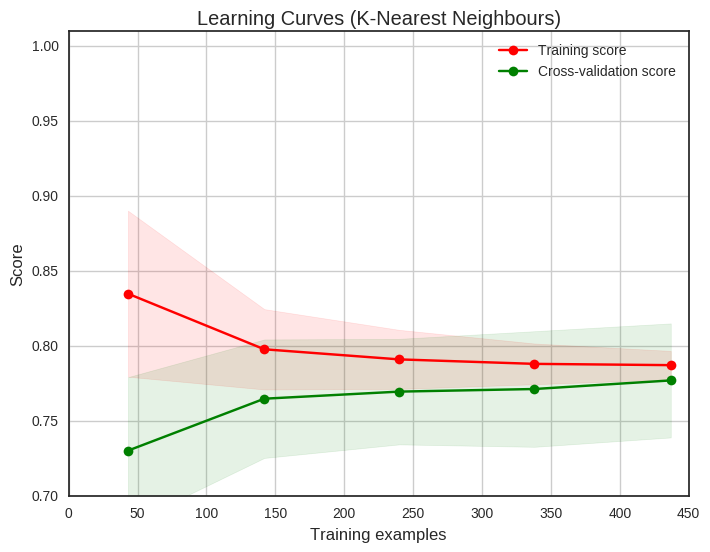

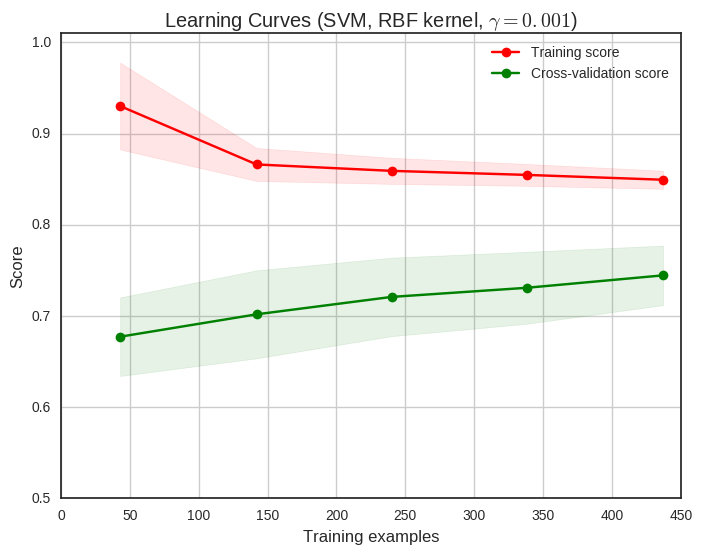

In [66]:
title = "Learning Curves (K-Nearest Neighbours)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X_train, y_train, (0.5, 1.01), cv=cv, n_jobs=4)

plt.show()

In [67]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [71]:
type(X_train.columns)

pandas.indexes.base.Index

In [83]:
dates = pd.date_range('20160101', periods=2)
class_names = pd.DataFrame({
    'Negative' : 0,
    'Positive' : 1
}, index = dates)

Confusion matrix, without normalization
[[94 19]
 [31 39]]
Normalized confusion matrix
[[ 0.83  0.17]
 [ 0.44  0.56]]


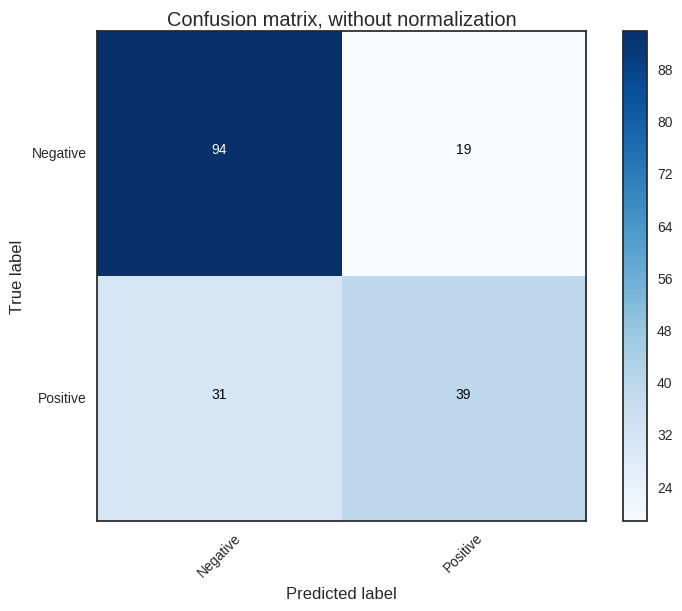

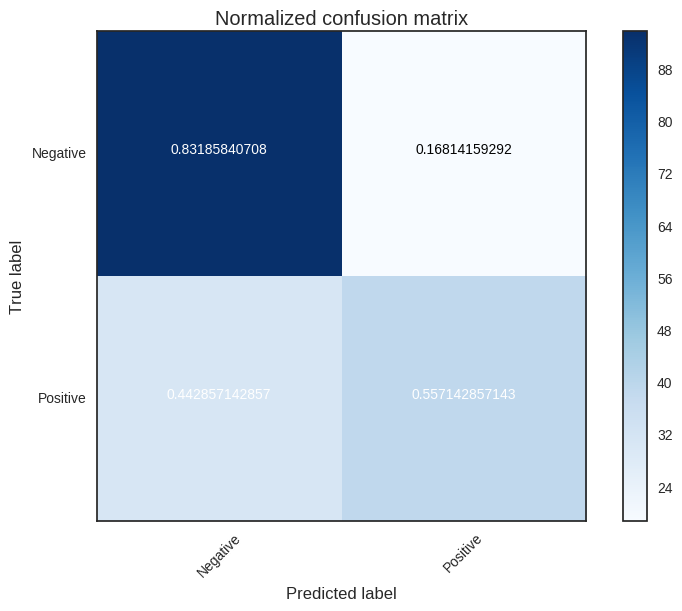

In [84]:
# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results

classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)

# class_names = X_train.columns
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Receiver Operating Characteristic (ROC)

Example of Receiver Operating Characteristic (ROC) metric to evaluate classifier output quality.
ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.
The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

# Multiclass settings

ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-class or multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).
Another evaluation measure for multi-class classification is macro-averaging, which gives equal weight to the classification of each label.

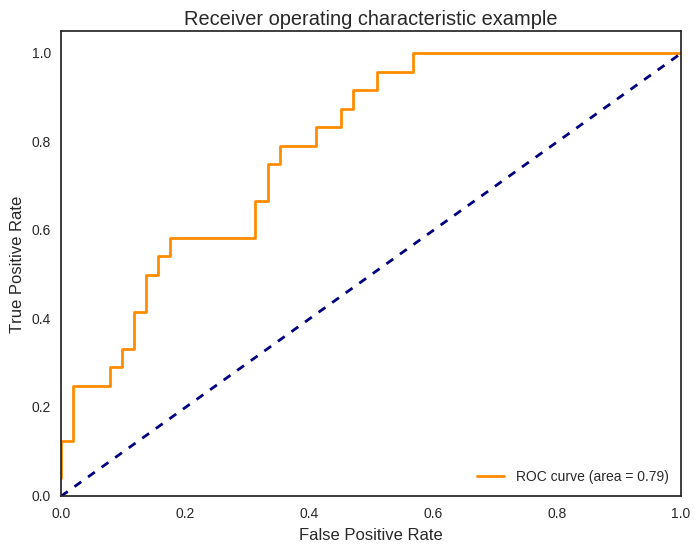

In [86]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

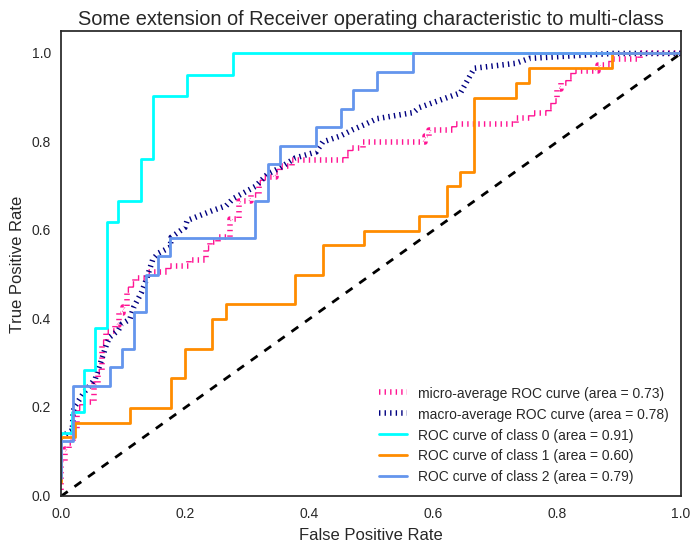

In [87]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Validation Curve

To validate a model we need a scoring function (see Model evaluation: quantifying the quality of predictions), for example accuracy for classifiers. The proper way of choosing multiple hyperparameters of an estimator are of course grid search or similar methods (see Tuning the hyper-parameters of an estimator) that select the hyperparameter with the maximum score on a validation set or multiple validation sets. Note that if we optimized the hyperparameters based on a validation score the validation score is biased and not a good estimate of the generalization any longer. To get a proper estimate of the generalization we have to compute the score on another test set.
However, it is sometimes helpful to plot the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values.
The function validation_curve can help in this case:

In [109]:
clf = SVC(kernel="linear", C=0.1)
clf.fit(X_train, y_train)
y_eval = clf.predict(X_test)

In [110]:
acc = sum(y_eval == y_test) / float(len(y_test))
print("Accuracy: %.2f%%" % (100*acc))

Accuracy: 80.21%


In [21]:
clf = SVC(kernel="linear", C=0.1)
scores_final = cross_val_score(clf, X, y, cv=5)

In [22]:
scores_final.mean(), scores_final.std()
print("Final model | Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores_final.mean(), 100*scores_final.std() * 2))

Final model | Accuracy: 76.83% (+/- 4.31%)
